In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [3]:
run_path = '/media/beans/ssd/blender_membank/dataloader_10/run_6' #random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 '/media/beans/ssd/blender_membank/dataloader_10/run_6')

In [4]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

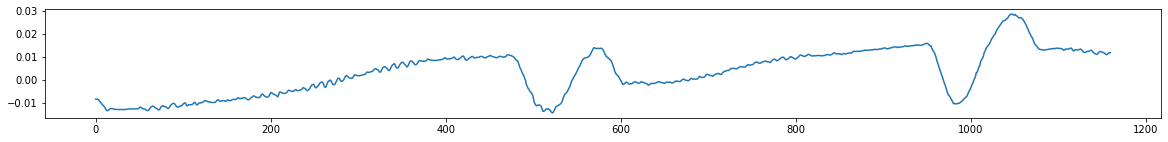

In [5]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

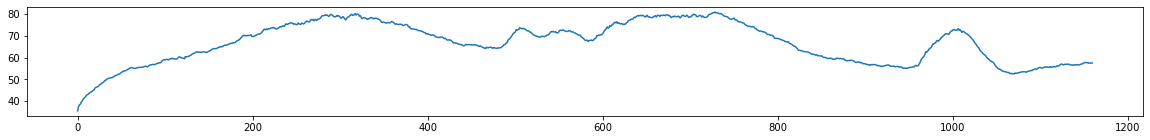

In [6]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [7]:
ix = 600

In [8]:
t = smooth_near_wps(targets[ix])

In [9]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [10]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

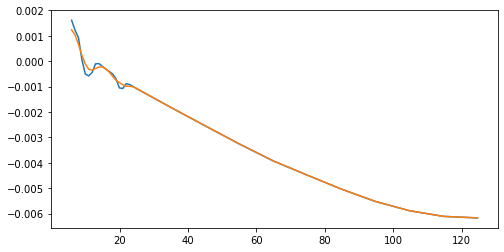

In [11]:
plt.figure(figsize=(8,4))
plt.plot(wp_dists[ix], targets[ix])
plt.plot(wp_dists[ix], t)

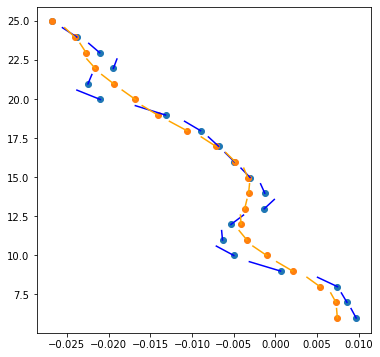

In [12]:
plt.figure(figsize=(6, 6))

plt.scatter(xs[:20], ys[:20])

for i in range(len(headings[:19])):
    h = headings[i]
    xd = np.sin(h)*SEGMENT_DISTS[i]*.6
    yd = np.cos(h)*SEGMENT_DISTS[i]*.6
    plt.plot([xs[i], xs[i]+xd], [ys[i], ys[i]+yd], 'Blue')

plt.scatter(xs_smoothed[:20], ys_smoothed[:20])

for i in range(len(headings[:19])):
    h = headings_smoothed[i]
    xd = np.sin(h)*SEGMENT_DISTS[i]*.6
    yd = np.cos(h)*SEGMENT_DISTS[i]*.6
    plt.plot([xs_smoothed[i], xs_smoothed[i]+xd], [ys_smoothed[i], ys_smoothed[i]+yd], 'Orange')

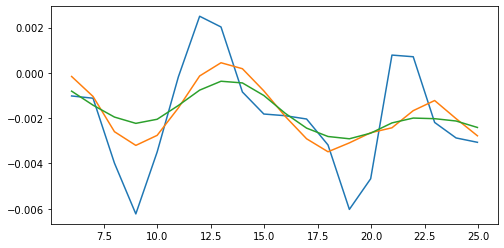

In [13]:
plt.figure(figsize=(8,4))
plt.plot(wp_dists[ix][:20], headings[:20])
plt.plot(wp_dists[ix][:20], headings_smoothed[:20])
plt.plot(wp_dists[ix][:20], smooth_near_wps(headings_smoothed)[:20])

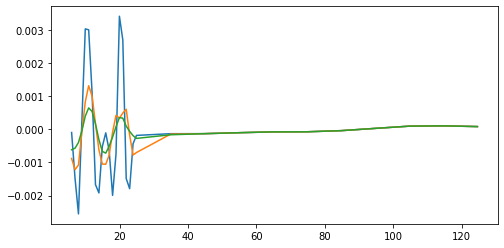

In [14]:
plt.figure(figsize=(8,4))
plt.plot(wp_dists[ix], get_curvatures_from_headings(headings))
plt.plot(wp_dists[ix], get_curvatures_from_headings(headings_smoothed))
plt.plot(wp_dists[ix], get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

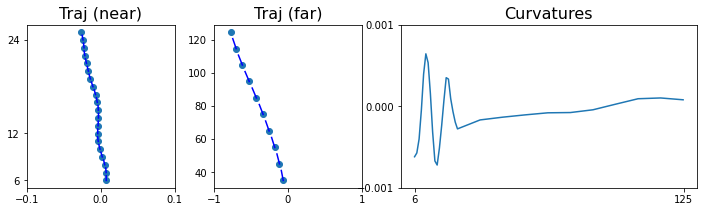

In [15]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

In [18]:
fig_to_img(fig, (100, 300, 3))

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [243]:
ccs = []
for i in range(len(targets)):
    h = get_headings_from_traj(targets[i], wp_dists[i])
    s = kph_to_mps(speeds[i])
    ccs.append(get_curve_constrained_speed(h, s))

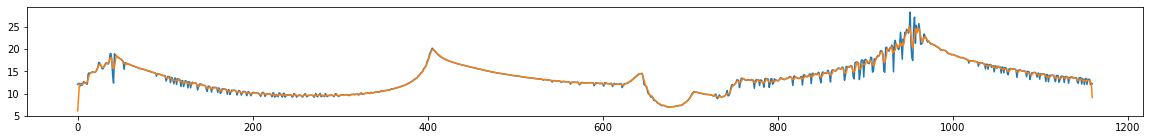

In [244]:
# curve constrained speeds
plt.figure(figsize=(20,2))
plt.plot(ccs)
plt.plot(moving_average(ccs, 4))

In [245]:
speeds.max()

81.06182

<BarContainer object of 10 artists>

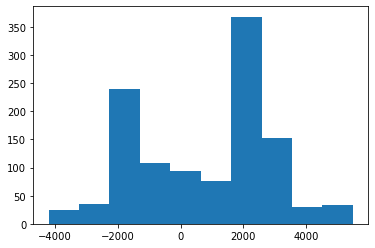

In [20]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

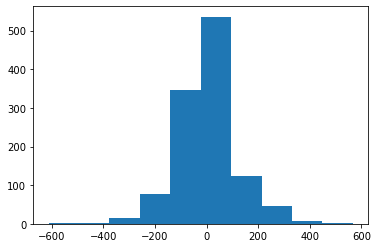

In [21]:
plt.hist(torque[1:]-torque[:-1])[2]

In [22]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [23]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [24]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)
imgs.shape, aux.shape

run_id = "sim"
model_stem = "7.10_avg"
make_vid(run_id, model_stem, imgs, aux, targets=targets)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [15]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 8.109466 ,  9.643675 , 11.56888  , 12.928512 ,  7.219473 ,
        8.632405 , 10.220134 ,  9.646809 ,  7.7737317, 12.136117 ,
       10.850284 , 12.768842 ], dtype=float32)

In [45]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [46]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.75 s, sys: 0 ns, total: 6.75 s
Wall time: 6.75 s


In [47]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [48]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((348, 1160, 30), (348, 1160, 30), (348, 1160, 30), (348, 1160, 30))

<BarContainer object of 40 artists>

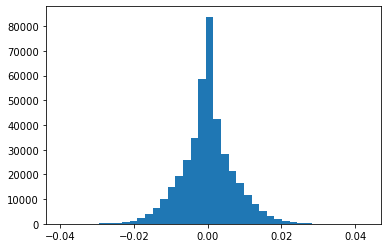

In [49]:
plt.hist(all_curvatures[:,:,2].flatten(), bins=40)[2]

In [94]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

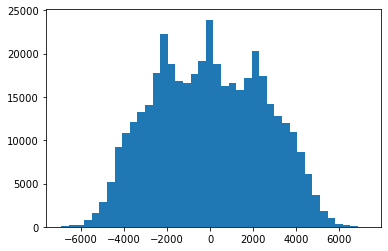

In [95]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

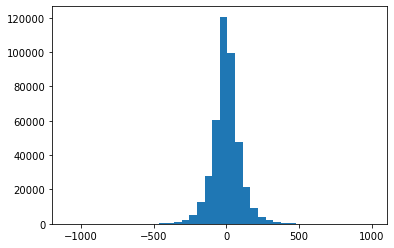

In [96]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [97]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(463.2444481524403, 6267.0884958267925)

In [98]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.995638,   6.994637,   7.993602,   8.99253 ,   9.991377,
        10.990188,  11.988926,  12.98757 ,  13.986117,  14.98455 ,
        15.982848,  16.980965,  17.978952,  18.976866,  19.974594,
        20.97217 ,  21.969555,  22.966846,  23.963943,  24.960863,
        34.92002 ,  44.8577  ,  54.770874,  64.65863 ,  74.51911 ,
        84.34995 ,  94.150696, 103.92116 , 113.66215 , 123.374176],
      dtype=float32)

<BarContainer object of 40 artists>

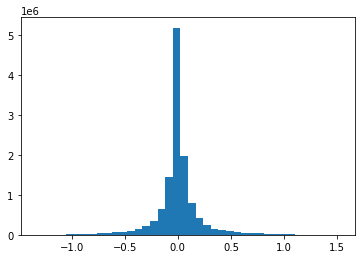

In [99]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [100]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02557581, 0.0294817 , 0.03332545, 0.03716544, 0.04098274,
       0.04476761, 0.04851102, 0.05216971, 0.05571661, 0.05918089,
       0.06260481, 0.06598821, 0.06935564, 0.07273806, 0.07616173,
       0.07963772, 0.08310309, 0.08651136, 0.08987916, 0.09319666,
       0.12488357, 0.15464026, 0.1819298 , 0.20662913, 0.22869396,
       0.24870318, 0.26659095, 0.28248549, 0.2963673 , 0.3033509 ],
      dtype=float32)

In [102]:
mean_headings[-1] / mean_headings[0]

11.860853

In [103]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01501583, 0.01664189, 0.01839747, 0.02021174, 0.02205646,
       0.02391624, 0.02578221, 0.02764774, 0.02950348, 0.0313437 ,
       0.03316661, 0.03497342, 0.03676248, 0.03853535, 0.04029406,
       0.04204177, 0.04378234, 0.04551685, 0.04724532, 0.04896694,
       0.06583856, 0.08189007, 0.09692572, 0.11099698, 0.12404112,
       0.13605092, 0.14708899, 0.15721036, 0.16646256, 0.1748872 ],
      dtype=float32)

In [104]:
mean_angles[-1] / mean_angles[0]

11.646854

In [106]:
mean_angles[0] / .015

1.0010553523898125

<BarContainer object of 40 artists>

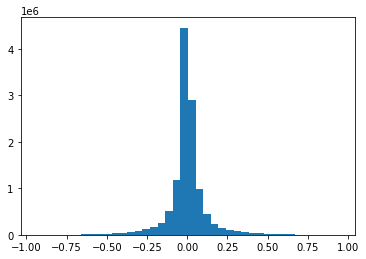

In [259]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

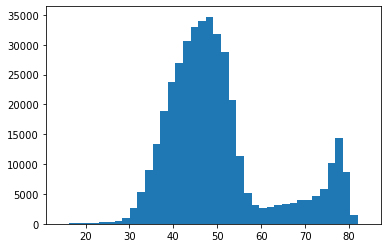

In [260]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]